In [19]:
import cv2
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import cmath
from scipy import ndimage
from scipy import optimize
from scipy import signal
from scipy import interpolate
from scipy.signal import find_peaks
from skimage.measure import profile_line

%matplotlib inline
# matplotlibのスタイル設定
plt.rcParams['figure.figsize'] = [4.8*2, 4.8*1]  # (default: [6.4, 4.8])
# plt.rcParams["font.family"] = "Times New Roman"      #全体のフォントを設定
plt.rcParams["xtick.direction"] = "in"               #x軸の目盛線を内向きへ
plt.rcParams["ytick.direction"] = "in"               #y軸の目盛線を内向きへ
plt.rcParams["xtick.minor.visible"] = True           #x軸補助目盛りの追加
plt.rcParams["ytick.minor.visible"] = True           #y軸補助目盛りの追加
# plt.rcParams["xtick.major.width"] = 1.5              #x軸主目盛り線の線幅
# plt.rcParams["ytick.major.width"] = 1.5              #y軸主目盛り線の線幅
# plt.rcParams["xtick.minor.width"] = 1.0              #x軸補助目盛り線の線幅
# plt.rcParams["ytick.minor.width"] = 1.0              #y軸補助目盛り線の線幅
# plt.rcParams["xtick.major.size"] = 10                #x軸主目盛り線の長さ
# plt.rcParams["ytick.major.size"] = 10                #y軸主目盛り線の長さ
# plt.rcParams["xtick.minor.size"] = 5                 #x軸補助目盛り線の長さ
# plt.rcParams["ytick.minor.size"] = 5                 #y軸補助目盛り線の長さ
plt.rcParams["font.size"] = 14                       #フォントの大きさ
# plt.rcParams["axes.linewidth"] = 1.5                 #囲みの太さ
# plt.style.use('fast')

def sin_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

def BoxLinprofToMaxIndex(pixel, lineprofile, peakdistance, plotTF):
    findpeakheight = 20
    diffProf = np.diff(lineprofile)
    # 導関数のプラス側ピーク検出
    diffProf_p = np.where( diffProf < 0, 0, diffProf ) # マイナス値をゼロに
    diffProf_pPeakIndex, _ = find_peaks(
        diffProf_p, height=findpeakheight, distance=peakdistance)
    # 導関数のマイナス側ピーク検出
    diffProf_m = np.where( diffProf > 0, 0, diffProf ) # プラス値をゼロに
    diffProf_mPeakIndex, _ = find_peaks(
        -1*diffProf_m, height=findpeakheight, distance=peakdistance)
    # ピーク点の整理して，そこから矩形の中点を求める
    if diffProf_pPeakIndex[0] > diffProf_mPeakIndex[0]:
        diffProf_mPeakIndex = diffProf_mPeakIndex[1::]
    if not len(diffProf_pPeakIndex) == len(diffProf_mPeakIndex):
        diffProf_pPeakIndex = diffProf_pPeakIndex[:-1:]
    if plotTF: # abs(diff) & ピーク検出をプロットして確認？
        fig, ax = plt.subplots(figsize=(10, 2))
        ax.plot(pixel[:-1:], np.abs(np.diff(lineprofile)))
        ax.scatter(pixel[diffProf_pPeakIndex], 
                   np.abs(np.diff(lineprofile))[diffProf_pPeakIndex],
                   color='b', label='peak', zorder=10)
        ax.scatter(pixel[diffProf_mPeakIndex], 
                   np.abs(np.diff(lineprofile))[diffProf_mPeakIndex],
                   color='g', label='peak', zorder=10)
        plt.show()    
    return ((diffProf_pPeakIndex+diffProf_mPeakIndex )/2).astype('int64')

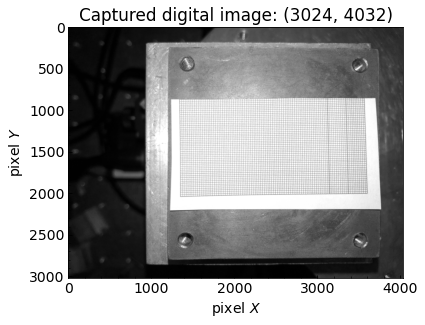

In [20]:
# ---------------------------
# allplotTF = 1 # 全プロット表示・非表示
cameraTF = 0  # カメラからイメージ取得？
camera_id = 1 # カメラID
# ---------------------------

if cameraTF:
    cap = cv2.VideoCapture(camera_id)
#     cap = cv2.VideoCapture('http://192.168.0.3:8080/video')
    ret, im = cap.read()
    cap.release()
if not cameraTF:
    im = cv2.imread('IMG_2782.jpg')  # 使用画像指定
# 白黒
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# 回転
im_gray = cv2.rotate(im_gray, cv2.ROTATE_90_CLOCKWISE)
# ガウシアンフィルタによる平滑化
# im_gray = cv2.GaussianBlur(im_gray, (1, 101), 10)
# 単純二値化
# ret, im_gray = cv2.threshold(im_gray, 0, 255, cv2.THRESH_OTSU)

# print("Image size: ", im_gray.shape)
# イメージプロット
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
ax.imshow(im_gray, cmap="gray")
ax.set_xlabel('pixel $X$')
ax.set_ylabel('pixel $Y$')
ax.set_title('Captured digital image: ('
             +str(im_gray.shape[0])+', '+str(im_gray.shape[1])+')')
plt.show()

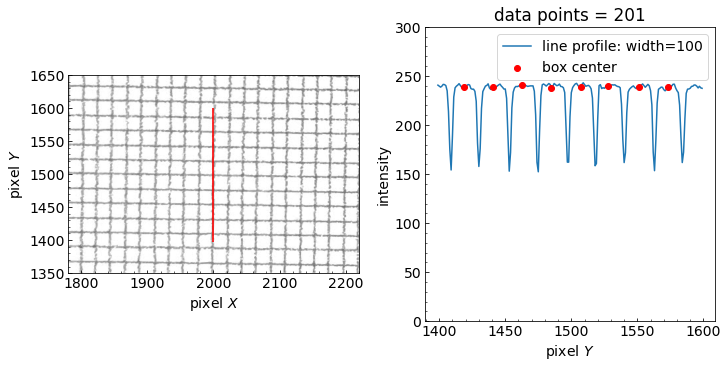

In [21]:
# ---------------------------
sinGridTF = 0 # sin波の格子縞？

centerX, centerY = 2000, 1500  # サンプリングのセンターピクセル指定
Vlength = 200 # 垂直方向のサンプリング長さ指定
V_linewidth = 100  # 垂直方向の平均化幅指定
Hlength = 400  # 水平方向のサンプリング長さ指定
H_linewidth = 1  # 水平方向の平均化幅指定
# ---------------------------

V_X, V_Y = centerX, centerY-int(Vlength/2)-1
Vstart, Vend = (V_Y, V_X), (V_Y+Vlength, V_X)  # x, yが逆
Vprofile = profile_line(im_gray, Vstart, Vend, linewidth=V_linewidth)
Vpixel = np.linspace(Vstart[0], Vend[0], len(Vprofile))

# 垂直プロファイルから水平プロファイルの取得インデックスを算出
if sinGridTF: # sin波格子縞の場合
    params, params_covariance = optimize.curve_fit(  # フィッティング
        sin_func, Vpixel, Vprofile, p0=[100, 0.15, 0, 150])
    print("fit. param. [a, b, c, d] =", params)
    VmaxIndex = signal.argrelextrema(sin_func(  # 最大値のインデックス
        Vpixel, params[0], params[1], params[2], params[3]), np.greater)
if not sinGridTF: # 矩形波格子縞の場合
    VmaxIndex = BoxLinprofToMaxIndex(Vpixel, Vprofile, 1, 0)

# プロット
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5), constrained_layout=True)
ax[0].set_aspect('equal')
ax[0].imshow(im_gray, cmap="gray", origin='upper')
ax[0].plot([Vstart[1], Vend[1]], [Vstart[0], Vend[0]], 'r-', lw=2, alpha=0.8)
ax[0].set_xlim( centerX-Hlength*(1.1/2), centerX+Hlength*(1.1/2) )
ax[0].set_ylim( centerY-Vlength*(1.5/2), centerY+Vlength*(1.5/2) )
ax[0].set_xlabel('pixel $X$')
ax[0].set_ylabel('pixel $Y$')
ax[1].plot(Vpixel, Vprofile,  label='line profile: width='+str(V_linewidth), zorder=9)
if sinGridTF:
    ax[1].plot(Vpixel, sin_func(Vpixel, params[0], params[1], params[2], params[3]),
               lw=5, alpha=0.5, label='sin fit.')
    ax[1].scatter(Vpixel[VmaxIndex],
                  sin_func(Vpixel, params[0], params[1],
                           params[2], params[3])[VmaxIndex],
                  color='r', label='max', zorder=10)
if not sinGridTF:
    ax[1].scatter(Vpixel[VmaxIndex], Vprofile[VmaxIndex],
                  color='r', label='box center', zorder=10)
ax[1].legend()
ax[1].set_title('data points = '+str(Vprofile.shape[0])+'')
ax[1].set_ylim(0, 300)
ax[1].set_xlabel('pixel $Y$')
ax[1].set_ylabel('intensity')
plt.show()

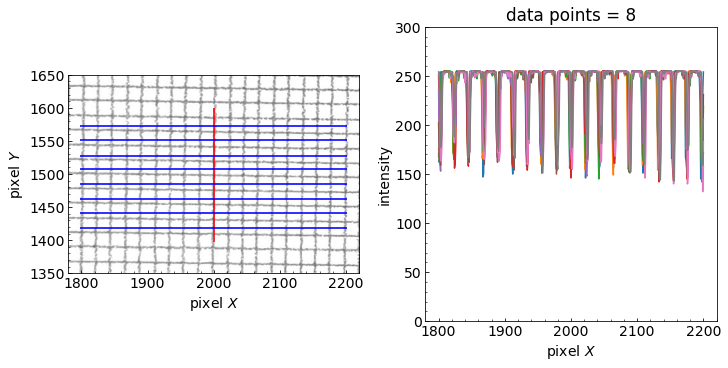

In [22]:
Hstart = [(H_Y, int(V_X-Hlength/2))
          for H_Y in Vpixel[VmaxIndex]]
Hend = [(H_Y, int(V_X+Hlength/2))
        for H_Y in Vpixel[VmaxIndex]]
Hprofiles = [profile_line(im_gray, Hstart_i, Hend_i, linewidth=H_linewidth)
             for (Hstart_i, Hend_i) in zip(Hstart, Hend)]
Hpixels = [np.linspace(Hstart_i[1], Hend_i[1], len(Hprofiles[0]))
           for (Hstart_i, Hend_i) in zip(Hstart, Hend)]

# プロット
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5), constrained_layout=True)
ax[0].set_aspect('equal')
ax[0].imshow(im_gray, cmap="gray", origin='upper')
ax[0].plot([Vstart[1], Vend[1]], [Vstart[0], Vend[0]], 'r-', lw=2, alpha=0.8)
for (Hstart_i, Hend_i) in zip(Hstart, Hend):
    ax[0].plot([Hstart_i[1], Hend_i[1]], 
               [Hstart_i[0], Hend_i[0]], 'b-', lw=2, alpha=0.8)
ax[0].set_xlim( centerX-Hlength*(1.1/2), centerX+Hlength*(1.1/2) )
ax[0].set_ylim( centerY-Vlength*(1.5/2), centerY+Vlength*(1.5/2) )
ax[0].set_xlabel('pixel $X$')
ax[0].set_ylabel('pixel $Y$')
for Hprofiles_i in Hprofiles:
    ax[1].plot(Hpixels[0], Hprofiles_i)
ax[1].set_title('data points = '+str(len(Hprofiles))+'')
ax[1].set_ylim(0, 300)
ax[1].set_xlabel('pixel $X$')
ax[1].set_ylabel('intensity')
plt.show()

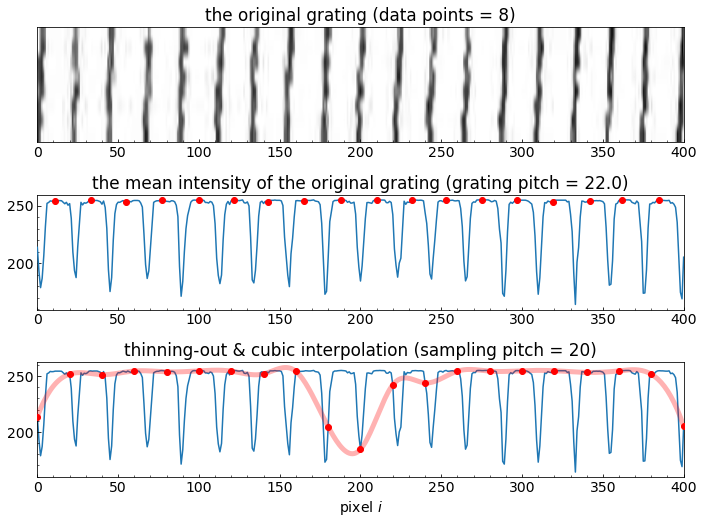

In [23]:
plotrow = 3
fig = plt.figure(figsize=(5*2, 5*plotrow/2), tight_layout=True)
# ---- original grating 
ax1 = fig.add_subplot(plotrow, 1, 1)
ax1.set_yticklabels([]) # 目盛りラベル削除
ax1.tick_params(axis='y', which='both', length=0) # 目盛り削除
ax1.set_title('the original grating (data points = '+str(len(Hprofiles))+')')
ax1.imshow(Hprofiles, cmap="gray", aspect='auto', origin='lower')

# ---- original grating: mean & get pich
HprofileMean = np.mean(Hprofiles, axis=0)
HprofileMean_i = np.arange(len(HprofileMean))

# ピッチを求める
if sinGridTF: # sin波格子縞の場合
    params, params_covariance = optimize.curve_fit(  # フィッティング
        sin_func, HprofileMean_i, HprofileMean, p0=[50, 0.15, 0, 100])
    # print("fit. param. [a, b, c, d] =", params)
    HmaxIndex = signal.argrelextrema(sin_func(  # 最大値のインデックス
        HprofileMean_i, params[0], params[1], params[2], params[3]), np.greater)
    HminIndex = signal.argrelextrema(sin_func(  # 最小値のインデックス
        HprofileMean_i, params[0], params[1], params[2], params[3]), np.less)
    pichMean = np.mean(np.concatenate( # 撮影された格子のピッチ
        [np.diff(HprofileMean_i[HmaxIndex]), np.diff(HprofileMean_i[HminIndex])]))
if not sinGridTF: # 矩形波格子縞の場合
    HmaxIndex = BoxLinprofToMaxIndex(
        Hpixels[0], Hprofiles[0], np.mean(np.diff(VmaxIndex))*0.9, 0)
    pichMean = np.mean(np.diff(HmaxIndex))

ax2 = fig.add_subplot(plotrow, 1, 2, sharex=ax1)
ax2.plot(HprofileMean, zorder=9)
if sinGridTF: # sin波格子縞の場合
    ax2.plot(HprofileMean_i,
             sin_func(HprofileMean_i, params[0], params[1], params[2], params[3]),
             lw=5, alpha=0.5, label='sin fit.')
if not sinGridTF: # 矩形波格子縞の場合
    ax2.scatter(HprofileMean_i[HmaxIndex], HprofileMean[HmaxIndex],
             color='r', label='box center', zorder=10)
ax2.set_xlim(0, len(HprofileMean)-1)
ax2.set_title('the mean intensity of the original grating (grating pitch = '
              + str(np.round(pichMean, 3))+')')

# ---- 間引き処理 & 補間 テスト
SamplingPitch_N = int(pichMean*0.95) # サンプリングピッチの設定
MoireFringe_i = HprofileMean_i[0::SamplingPitch_N]
MoireFringe = HprofileMean[MoireFringe_i]
# Interp_kind = "quadratic" # 2次スプライン補間
Interp_kind = "cubic"  # 3次スプライン補間
MoireInterpolate = interpolate.interp1d(
    MoireFringe_i, MoireFringe, kind=Interp_kind, fill_value="extrapolate")

ax3 = fig.add_subplot(plotrow, 1, 3, sharex=ax1)
ax3.set_title('thinning-out & ' + Interp_kind
              + ' interpolation (sampling pitch = '
              + str(SamplingPitch_N)+')')
ax3.plot(HprofileMean_i, HprofileMean, zorder=1)
ax3.scatter(MoireFringe_i, MoireFringe,
            color='r', label='max', zorder=10)
ax3.plot(HprofileMean_i, MoireInterpolate(HprofileMean_i),
         lw=5, alpha=0.3, color='r', zorder=9)
ax3.set_xlabel('pixel $i$')

plt.show()

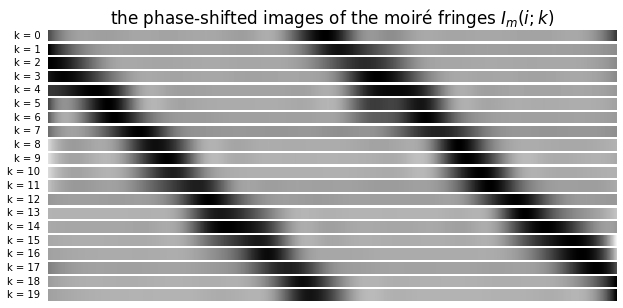

In [24]:
# ---- 間引き処理 & 補間
MoireInterpolates = []
for start_i in range(SamplingPitch_N):
    MoireFringe_i = HprofileMean_i[start_i::SamplingPitch_N]
    MoireFringe = HprofileMean[MoireFringe_i]
    MoireInterpolate = interpolate.interp1d(
        MoireFringe_i, MoireFringe, kind=Interp_kind, fill_value="extrapolate")
    MoireInterpolates.append(MoireInterpolate(HprofileMean_i))
MoireInterpolates = np.array(MoireInterpolates)


fig, axes = plt.subplots(nrows=SamplingPitch_N, figsize=(5*2, len(MoireInterpolates)*0.2))
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
axes[0].set_title('the phase-shifted images of the moiré fringes $I_m(i;k)$')
vmax = np.max(MoireInterpolates)*1.02
for i, (ax, MoireInterp_i) in enumerate(zip(axes, MoireInterpolates)):
    temp = np.vstack([MoireInterp_i, MoireInterp_i])
    ax.imshow(temp, aspect='auto', cmap="gray", vmax=vmax)
    pos = list(ax.get_position().bounds)
    x_text = pos[0] - 0.01
    y_text = pos[1] + pos[3]/2.
    fig.text(x_text, y_text, "k = "+str(i), va='center', ha='right', fontsize=10)
for ax in axes:
    ax.set_axis_off()
plt.show()

$
{\rm phase\ analysis:\ } {\varphi_m}(i) 
= \varphi (i) - {\varphi_s}(i) 
= \arg \left[ {\sum\limits_{{k = 0}}^{{{p_s} - 1}} {{I_m}(i;k){ \exp }\left( { - 2j\pi \frac{k}{{{p_s}}}} \right)} } \right]
$

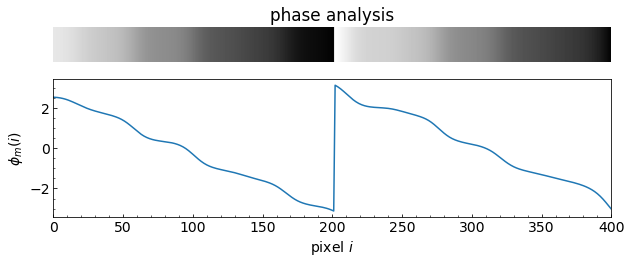

In [25]:
# ---- FFT (DFT)
def DFT(Im):
    p_s = len(Im)
    Im_k = np.array([Im[k] * np.e**( -2j * np.pi * ( k / p_s ))
                     for k in range(p_s)])
    return np.sum(Im_k)

# print(DFT(MoireInterpolates[:,0]))
# print(-cmath.phase(DFT(MoireInterpolates[:,0])))
phi = [cmath.phase(DFT(MoireInterpolates[:,i]))
       for i in HprofileMean_i]
# print(phi)
fig = plt.figure(figsize=(5*2, 5*0.7))
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[1, 4])
ax0 = fig.add_subplot(spec[0])
ax0.set_title('phase analysis')
phi_temp = np.vstack([phi, phi])
ax0.imshow(phi_temp, aspect='auto', cmap="gray", vmin=-np.pi, vmax=np.pi)
ax0.set_axis_off()

ax1 = fig.add_subplot(spec[1])
ax1.set_title('')
ax1.plot(HprofileMean_i, phi, zorder=1)
ax1.set_xlim(0, len(HprofileMean_i)-1)
ax1.set_xlabel('pixel $i$')
ax1.set_ylabel('$\phi_m(i)$')
plt.show()

In [8]:
phi0 = phi

In [17]:
phi1 = phi

変位後画像との位相差

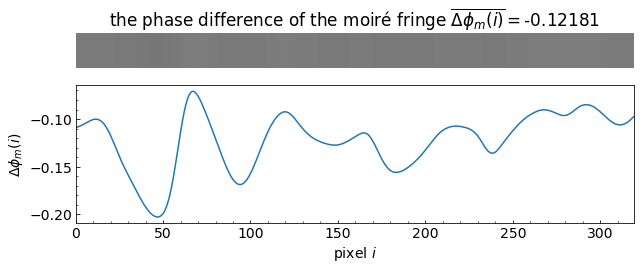

the displacement distribution: -0.4265054422


In [18]:
# 位相差
D_theta = np.array(phi1)-np.array(phi0)
# 位相差を-piからpiの間に変換
Delta_phi = np.arctan2(np.sin(D_theta), np.cos(D_theta))
# 両端のデータを削除
Delta_phi = Delta_phi[0+int(0.1*len(Delta_phi)):
                      (len(Delta_phi)-1)-int(0.1*len(Delta_phi)):]
# print(len(Delta_phi))
# print(np.average(Delta_phi))
fig = plt.figure(figsize=(5*2, 5*0.7))
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[1, 4])
ax0 = fig.add_subplot(spec[0])
ax0.set_title('the phase difference of the moiré fringe $\overline{\Delta \phi_m(i)} = $'
              +str(np.round(np.average(Delta_phi),5)))
temp = np.vstack([Delta_phi, Delta_phi])
ax0.imshow(temp, aspect='auto', cmap="gray", vmin=-np.pi, vmax=np.pi)
ax0.set_axis_off()

ax1 = fig.add_subplot(spec[1])
ax1.set_title('')
ax1.plot(Delta_phi, zorder=1)
ax1.set_xlim(0, len(Delta_phi)-1)
ax1.set_xlabel('pixel $i$')
ax1.set_ylabel('$\Delta \phi_m(i)$')
plt.show()

print('the displacement distribution: '+str(np.round((pichMean/(2*np.pi))*np.average(Delta_phi),10)))